# Projet 7 : Réaliser une analyse de sentiments grâce au Deep Learning

## Contexte
* **Entreprise:** Air Paradis, compagnie aérienne.
* **Problématique:**
    * Préparer un prototype fonctionnel du modèle. Le modèle est exposé via une API déployée sur le Cloud, appelée par une interface locale (notebook ou application Streamlit) qui envoie un tweet à l’API et récupère la prédiction de sentiment.
    * Préparer un support de présentation explicitant les méthodologies utilisées pour les différentes approches (attention : audience non technique)

* **Objectif:** Développer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux.

## Données
* **TWEETS:**

## Approches Envisagées
* **Traitement du Langage Naturel:**
    * Vectorisation des descriptions textuelles.
    * Utilisation de modèles de classification (Naive Bayes, SVM, etc.).

## Bénéfices Attendus
* **Gain de temps:** Automatisation d'une tâche répétitive.
* **Amélioration de la qualité des données:** Catégorisation plus précise et cohérente des sentiments.
* **Passage à l'échelle:** Facilité pour gérer un volume de tweets.

# I. Importation

### A. Importation des bibliothèques

In [1]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### B. Importation du fichier

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', header=None)
data = df.copy()
# Renommer les colonnes
data.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
# Renommer les catégories de sentiments (0 = negative, 4 = positive)
data['target'] = data['target'].replace(4, 1)

### II. Supprimer les individus dupliqués

In [3]:
# Suppression des doublons pour id en conservant la première occurrence
data_without_duplicated = data.drop_duplicates(subset='id', keep='first')

# Suppression des doublons pour date, user, texte en conservant la première occurrence
data = data_without_duplicated.drop_duplicates(subset=['date', 'user', 'text'], keep='first')

print(data.shape)

(1598127, 6)


Le DataFrame contient 1598127 tweets, décrits par 6 caractéristiques. La cible qui est le sentiment négatif égal à 0 et le sentiment positif égal à 1. Les caractéristiques explicatives sont l'identifiant du tweets, le flag, la date, le rédacteur et le texte.

L'analyse préliminaire révèle une qualité de données satisfaisante, avec peu de valeurs manquantes.

# III. Division du dataset

In [4]:
from sklearn.model_selection import train_test_split
# Sélectionner le dataset utile
X, X_useless, y, y_useless = train_test_split(data["text"],
                                                    data["target"],
                                                    test_size = 0.90, stratify=data["target"])
# Diviser le dataset en train et test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15, stratify=y)
# Diviser le train en train et val
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.15, stratify=y_train)

In [5]:
print(f"Entraînement : tweets --> {X_train.shape[0]} et étiquettes --> {y_train.shape[0]}")
print(f"Validation : tweets --> {X_val.shape[0]} et étiquettes --> {y_val.shape[0]}")
print(f"Test : tweets --> {X_test.shape[0]} et étiquettes --> {y_test.shape[0]}")

Entraînement : tweets --> 115464 et étiquettes --> 115464
Validation : tweets --> 20376 et étiquettes --> 20376
Test : tweets --> 23972 et étiquettes --> 23972


# VI. Comparaison Modèles avancés: BERT

BERT signifie Bidirectionnel Encoders Representations from Transformers.

* Bidirectionnel - pour comprendre le texte que vous regardez, vous devrez regarder en arrière (les mots précédents) et en avant (les mots suivants)

* Le Transformer lit des séquences entières de jetons à la fois.

* Dans un sens, le modèle est non directionnel, tandis que les LSTM lisent séquentiellement (de gauche à droite ou de droite à gauche). Le mécanisme d'attention permet d'apprendre les relations contextuelles entre les mots.

* Embeddings de mots contextualisées (pré-entraînées) - une manière d'encoder des mots en fonction de leur signification/contexte.

In [6]:
# L'espace de stockage n'est pas un problème donc ignorer le warning.
import warnings
warnings.filterwarnings("ignore")
# Importer le tokenizer et le modèle.
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## A. Encodage

Afin d'utiliser les textes encodés BERT comme entrée pour former le modèle de classification de texte,je dois les tokeniser. La tokenisation fait référence à la division d'une phrase en mots individuels. Pour tokeniser notre texte, nous utiliserons le tokenizer BERT.

In [ ]:
# Tokenizer les données d'entrainement et de test.
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

## B. Entrainement

In [ ]:
import torch
from tqdm import tqdm

# Convertir les données tokenizées en PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(y_train.tolist()))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(y_val.tolist()))

# Charger les données.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

In [12]:
# Definir l'optimiseur et la fonction de perte.
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Fine-tune le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Utilisant le dispositif :", device)
model.to(device)

# Definire les couches à freeze
num_frozen_layers = 6
for param in model.distilbert.transformer.layer[:num_frozen_layers].parameters():
    param.requires_grad = False
val_loss_values = []
for epoch in range(10):
    val_loss_mean = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        predictions = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = predictions.logits
        loss = loss_fn(logits, labels)
        
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    for val_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}"):
        val_input_ids = val_batch[0].to(device)
        val_attention_mask = val_batch[1].to(device)
        val_labels = val_batch[2].to(device)
        
        val_predictions = model(val_input_ids, attention_mask=val_attention_mask, labels=val_labels)
        val_logits = val_predictions.logits
        val_loss = loss_fn(val_logits, val_labels)
        val_loss_values.append(val_loss.cpu().item())
        
        torch.cuda.empty_cache()
    val_loss_mean = np.mean(val_loss_values)
    print(f"Epoch {epoch+1}, Val_Loss: {val_loss}")

Utilisant le dispositif : cuda


Epoch 1: 100%|██████████| 1805/1805 [02:41<00:00, 11.19it/s]


Epoch 1, Loss: 0.0001


Epoch 1: 100%|██████████| 319/319 [00:11<00:00, 28.91it/s]


Epoch 1, Val_Loss: 1.5110969543457031


Epoch 2: 100%|██████████| 1805/1805 [02:41<00:00, 11.20it/s]


Epoch 2, Loss: 0.0001


Epoch 2: 100%|██████████| 319/319 [00:11<00:00, 28.92it/s]


Epoch 2, Val_Loss: 1.6119861602783203


Epoch 3: 100%|██████████| 1805/1805 [02:41<00:00, 11.20it/s]


Epoch 3, Loss: 0.0000


Epoch 3: 100%|██████████| 319/319 [00:11<00:00, 28.68it/s]


Epoch 3, Val_Loss: 1.090192198753357


Epoch 4: 100%|██████████| 1805/1805 [02:41<00:00, 11.21it/s]


Epoch 4, Loss: 0.0000


Epoch 4: 100%|██████████| 319/319 [00:11<00:00, 28.54it/s]


Epoch 4, Val_Loss: 1.3204165697097778


Epoch 5: 100%|██████████| 1805/1805 [02:41<00:00, 11.20it/s]


Epoch 5, Loss: 0.0000


Epoch 5: 100%|██████████| 319/319 [00:11<00:00, 28.36it/s]


Epoch 5, Val_Loss: 1.7740060091018677


Epoch 6: 100%|██████████| 1805/1805 [02:41<00:00, 11.21it/s]


Epoch 6, Loss: 0.0000


Epoch 6: 100%|██████████| 319/319 [00:11<00:00, 28.53it/s]


Epoch 6, Val_Loss: 0.9750421047210693


Epoch 7: 100%|██████████| 1805/1805 [02:40<00:00, 11.21it/s]


Epoch 7, Loss: 0.0000


Epoch 7: 100%|██████████| 319/319 [00:10<00:00, 29.08it/s]


Epoch 7, Val_Loss: 0.9500213265419006


Epoch 8: 100%|██████████| 1805/1805 [02:41<00:00, 11.19it/s]


Epoch 8, Loss: 0.0002


Epoch 8: 100%|██████████| 319/319 [00:11<00:00, 28.98it/s]


Epoch 8, Val_Loss: 1.4394394159317017


Epoch 9: 100%|██████████| 1805/1805 [02:41<00:00, 11.20it/s]


Epoch 9, Loss: 0.0000


Epoch 9: 100%|██████████| 319/319 [00:11<00:00, 28.73it/s]


Epoch 9, Val_Loss: 1.1801820993423462


Epoch 10: 100%|██████████| 1805/1805 [02:41<00:00, 11.20it/s]


Epoch 10, Loss: 0.0000


Epoch 10: 100%|██████████| 319/319 [00:11<00:00, 28.43it/s]

Epoch 10, Val_Loss: 1.1444588899612427


In [37]:
for name, param in model.named_parameters():
    print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

In [13]:
torch.save(model, 'bert_model.pth')

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
torch.save(tokenizer, 'tokenizer.pth')

publié dans space hugging face (model mit en cache)
api appel le model depuis hugging face 
api sur github - intégration et délpoyement continue (3 test unitaire == 3 test cas == pytest va chercher dans ripo tous les script mot test - class). test partie prétraitement.

git hub --> déployement continue, intégration continue (test unitaire)
hugging face --> stockage model et mise en cache dans azure (https://huggingface.co/docs/transformers/model_sharing)

MLFlow traking de test expérimentation permet la tracabilité de l'ensemble des expérimentation. 

Pour chaque itération save paramètres : 

* Artifact (file servant à l'entrainement : docker file, dataset). 
* Ensemble des hyperparamètres (100 jeux par exemples).
* Métriques.
* résultats.
* stocke après sérialisation model.

Intégration python. Fonctionne mode client serveur. peux accéder en écrivant MLFlow -ui. Permet de déployer facilement comme une api. Log : sql/json.

Régler les hyperparamètres (gred search)

tester l'api en local puis déployement

## C. Test

In [18]:
# Importer le modèle
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Utilisant le dispositif :", device)

model = torch.load('bert_model.pth', weights_only=False)
model.to(device)

Utilisant le dispositif : cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [19]:
# Tokenizer les données test.
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
# Charger les données.
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), torch.tensor(y_test.tolist()))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

0.8108626731186385


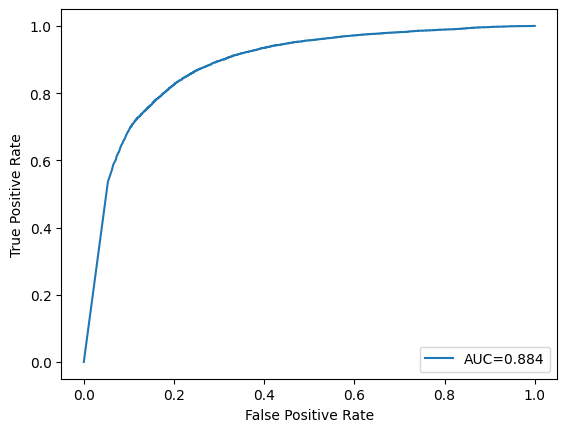

              precision    recall  f1-score   support

           0       0.84      0.77      0.80     11999
           1       0.79      0.85      0.82     11973

    accuracy                           0.81     23972
   macro avg       0.81      0.81      0.81     23972
weighted avg       0.81      0.81      0.81     23972



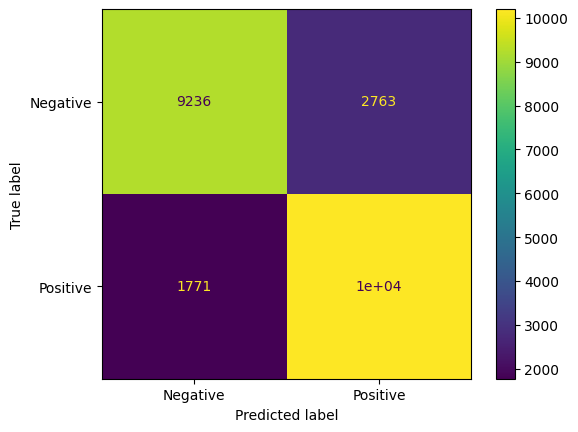

Accuracy: 0.8109
AUC-ROC Score: 0.8845


In [13]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluer le modèle
def evaluate_model(model, test_loader, y_test):
  """
  Evaluates a trained model on the test set.

  Args:
      model: The trained model to evaluate.
      X_test: The test data.
      y_test: The true labels for the test data.

  Returns:
      A dictionary containing various evaluation metrics.
  """
  preds = []
  preds_proba = []
  model.eval()
  with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        predictions = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = predictions.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).cpu().tolist()
        preds_proba.extend(probabilities.cpu().tolist())
        preds.extend(predicted_class)

    # Calculer accuracy
    accuracy = accuracy_score(y_test, preds)
    print(accuracy)

    # Calculer AUC-ROC score
    auc_score = roc_auc_score(y_test, np.array(preds_proba)[:, 1])

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, np.array(preds_proba)[:, 1])
    plt.plot(fpr, tpr, label="AUC=" + str(round(auc_score, 3)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Print classification report
    print(classification_report(y_test, preds))

    # Create and display confusion matrix
    cf_matrix = confusion_matrix(y_test, preds)
    cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=["Negative", "Positive"])
    cmd.plot()
    plt.show()

    return {
        "accuracy": accuracy,
        "auc_score": auc_score
    }

# Evaluate the fine-tuned model
evaluation_results = evaluate_model(model, test_loader, y_test)
print(f"Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"AUC-ROC Score: {evaluation_results['auc_score']:.4f}")